# Mutational signatures analysis on the clones derived from Tumor2 (case3)
- Mutations from the clones are taken from Strelka variant caller
- Mutations from the MRT tumor sample are taken from the vcf processing using several normal tissues
   - ```../../case3_normal_tissues/vcf_postprocessing/```
- Siganture analysis performed with mSigAct

## Prepare mutation tables with clonals

In [1]:
import pandas as pd
import pybedtools
import json
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import numpy as np

In [2]:
def cnv_snvs_intersect (cnv_df,snvs_df):
    '''Adds CN information in snvs/indels mafs
    input: cn dataframe from ASCAT output (.cnvs.txt) and snvs/indels dataframe from maf files
    output: dataframe with integrated CN info to vc mafs'''
    
    #Preapre cnv_df
    cnv_bt_df = cnv_df.copy(deep=True)
    cnv_bt_df['CN'] = cnv_bt_df['nMajor']+cnv_bt_df['nMinor']
    cnv_bt_df['chr'] = 'chr' + cnv_bt_df['chr']

    #Prepare snvs_df
    snvs_bt_df = snvs_df.copy(deep=True)
    snvs_bt_df['POS2'] = snvs_bt_df['POS'] + 1
    snvs_bt_df = snvs_bt_df[['#CHROM','POS','POS2','REF','ALT']]

    #pybedtools cnv + snvs
    cnv_bt = pybedtools.BedTool.from_dataframe(cnv_bt_df)
    snvs_bt = pybedtools.BedTool.from_dataframe(snvs_bt_df)

    cnv_and_snvs = cnv_bt.intersect(snvs_bt)

    #Pass intersection to dataframe
    snvs_cnv_df = cnv_and_snvs.to_dataframe()
    snvs_cnv_df = snvs_cnv_df.rename(columns={'chrom':'#CHROM','start':'POS','end':'POS2',
                                              'name':'nMinor','score':'nMajor','strand':'CN'})
    snvs_cnv_df = snvs_cnv_df.drop(columns=['POS2'])

    #Merge intersect with snvs_df
    snvs_cnv_df = pd.merge(snvs_df,snvs_cnv_df,how='left')
    return snvs_cnv_df

def calculate_VAF(reads_alt,reads_ref):
    '''Calculate VAF from number of reads
    input: number of reads alternate allele, number of reads reference allele
    output: variant allele frequency'''
    if reads_alt == reads_ref == 0:
        return 0
    else:
        vaf = round (reads_alt/(reads_alt+reads_ref),3)
        return vaf

def calculate_ccf (vaf,cnv,purity):
    '''Calculate CCF from VAF, CN and purity
    input: variant allele frequency, copy number, purity(.purityploidy.txt file from ASCAT)
    output: cancer cell fraction'''
    ccf = vaf*(purity*cnv+ (1-purity)*2)/purity
    return ccf

def final_dataframe (path_cnv,path_purity,path_caller,vc,purity='purple'):
    '''Reads vc mafs and ASCAT output, makes intersect snvs and CN and adds columns calculated 
    with VAF and CCF
    input: patient, tumor sample id, normal sample id and caller type
    output: final dataframe with CN, VAF and CCF information added'''
    
    #Read vc mafs and ASCAT output
    cnv_df = pd.read_csv(path_cnv,sep='\t')      
    if purity == 'ascat':
        purity = pd.read_csv(path_purity,sep='\t')
        #Get purity
        purity = purity['AberrantCellFraction'][0]
    elif purity == 'purple':
        purity = pd.read_csv(path_purity,sep='\t')
        #Get purity
        purity = purity['purity'][0]
    
    if vc == 'mutect':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    elif vc =='strelka':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    elif vc == 'sage':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    elif vc == 'intersect':
        snvs_df = pd.read_csv(path_caller,sep='\t')
    else:
        print('Specify variant caller: mutect, strelka, sage, intersect')
    
    #Get df with cn and snv intersect
    df = cnv_snvs_intersect(cnv_df,snvs_df)
  
    #Calculate AF and CCF
    df['t_AF'] = df.apply(lambda row: calculate_VAF(row['t_alt_reads'],row['t_ref_reads']),axis=1)
    df['n_AF'] = df.apply(lambda row: calculate_VAF(row['n_alt_reads'],row['n_ref_reads']),axis=1)
    df['t_CCF'] = df.apply(lambda row: calculate_ccf(row['t_AF'],row['CN'],purity),axis=1)
    df['n_CCF'] = df.apply(lambda row: calculate_ccf(row['n_AF'],row['CN'],purity),axis=1)
    df['purity'] = purity
    
    return df

In [3]:
#import purity and cnv information from ascat (sarek)

#This commented path points to the original data
# path_to_sarek = '/workspace/datasets/sjd_seq/sarek_results/pt1/results/'

#Adapt this path accordingly
path_to_sarek = 'path/to/sarek/output/'

path_cnv = path_to_sarek + 'variant_calling/ascat/AX4958_vs_AQ5174/AX4958_vs_AQ5174.cnvs.txt'
path_purity = path_to_sarek+'variant_calling/ascat/AX4958_vs_AQ5174/AX4958_vs_AQ5174.purityploidy.txt'
path_caller = '../vcf_postprocessing/output/case3/AX4958_vs_AQ5174/vcf_processing/strelka/AX4958_vs_AQ5174_process.maf.gz'
df2 = final_dataframe(path_cnv,path_purity,path_caller,vc='strelka',purity='ascat')
path_cnv = path_to_sarek+'variant_calling/ascat/AX4961_vs_AQ5174/AX4961_vs_AQ5174.cnvs.txt'
path_purity = path_to_sarek+'variant_calling/ascat/AX4961_vs_AQ5174/AX4961_vs_AQ5174.purityploidy.txt'
path_caller = '../vcf_postprocessing/output/case3/AX4961_vs_AQ5174/vcf_processing/strelka/AX4961_vs_AQ5174_process.maf.gz'
df3 = final_dataframe(path_cnv,path_purity,path_caller,vc='strelka',purity='ascat')


In [4]:
#upload precalculated clonality threshold
thresholds = json.load(open('../vcf_postprocessing/ccf_thresholds_case3_t2_clones.json','r'))
thresholds

{'case3_c1': 0.7607865512511622, 'case3_c2': 0.5709676625152742}

In [5]:
#upload snvs from tumor 2 (MRT), after normal tissues analysis
df1 = pd.read_csv('../../case3_normal_tissues/vcf_postprocessing/output/08_final_list_muts.tsv.gz',sep='\t')

#and select clonal mutations from MRT
dfc1 = df1[((df1['AF_t1']>=0.25)&(df1['AF_t2']==0))|((df1['AF_t2']>=0.2)&(df1['AF_t1']==0))|((df1['AF_t1']>=0.25)&(df1['AF_t2']>=0.2))]
dfc1 = dfc1[(dfc1['denovo_germline']==False)&(dfc1['AF_t2']!=0)&(dfc1['AF_t1']==0)&(dfc1['mut_type']=='snv')]

In [6]:
#select snvs from clones
df2['snv'] = df2.apply(lambda row: True if len(row['REF']) == len(row['ALT'])==1 else False,axis=1)
df3['snv'] = df3.apply(lambda row: True if len(row['REF']) == len(row['ALT'])==1 else False,axis=1)
df2 = df2[df2['snv']==True]
df3 = df3[df3['snv']==True]

In [7]:
#select clonals
threshold = thresholds['case3_c1']
dfc2 = df2[df2['t_CCF']>threshold]
threshold = thresholds['case3_c2']
dfc3 = df3[df3['t_CCF']>threshold]

In [27]:
print('clonals:',len(dfc1),'MRT')
print('totals:',len(df2),'clonals:',len(dfc2),'Clone1')
print('totals:',len(df3),'clonals',len(dfc3),'Clone2')

clonals: 1149 MRT
totals: 6811 clonals: 4541 Clone1
totals: 6525 clonals 4615 Clone2


In [9]:
#prepare dataframe for signature fitting
dfc1['SAMPLE'] = 'AQ5186_vs_AQ5174'
dfc2['SAMPLE'] = 'AX4958_vs_AQ5174'
dfc3['SAMPLE'] = 'AX4961_vs_AQ5174'
dfc2 = dfc2.rename(columns={'#CHROM':'CHROM'})
dfc3 = dfc3.rename(columns={'#CHROM':'CHROM'})
df = pd.concat([dfc1,dfc2,dfc3],ignore_index=True)
cols = ['CHROM','POS','REF','ALT','SAMPLE']
df['snv'] = df.apply(lambda row: True if len(row['REF']) == len(row['ALT'])==1 else False,axis=1)
df = df[df['snv']==True]
df = df[cols]
df

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CHROM,POS,REF,ALT,SAMPLE
0,chr1,865445,G,C,AQ5186_vs_AQ5174
1,chr1,4101122,G,T,AQ5186_vs_AQ5174
2,chr1,4352976,G,A,AQ5186_vs_AQ5174
3,chr1,7591505,T,C,AQ5186_vs_AQ5174
4,chr1,7983849,G,T,AQ5186_vs_AQ5174
...,...,...,...,...,...
10300,chrX,153760660,C,T,AX4961_vs_AQ5174
10301,chrX,153905418,T,C,AX4961_vs_AQ5174
10302,chrX,154436952,G,C,AX4961_vs_AQ5174
10303,chrX,154452484,G,A,AX4961_vs_AQ5174


In [10]:
df.to_csv('./input/clonals_case3_t2.tsv.gz',sep='\t',index=None,compression='gzip')

### Prepare venn diagramm with overlap clonal mutations

In [12]:
cols = ['CHROM','POS','REF','ALT']
common_df = pd.merge(dfc1[cols],dfc2[cols],how='outer',indicator='MRT')
common_df['Clone1'] = common_df['MRT']
common_df['MRT'] = common_df['MRT'].replace('both',True)
common_df['MRT'] = common_df['MRT'].replace('left_only',True)
common_df['MRT'] = common_df['MRT'].replace('right_only',False)
common_df['Clone1'] = common_df['Clone1'].replace('both',True)
common_df['Clone1'] = common_df['Clone1'].replace('left_only',False)
common_df['Clone1'] = common_df['Clone1'].replace('right_only',True)
common_df = pd.merge(common_df,dfc3[cols],how='outer',indicator='Clone2')
common_df['Clone2'] = common_df['Clone2'].replace('both',True)
common_df['Clone2'] = common_df['Clone2'].replace('left_only',False)
common_df['Clone2'] = common_df['Clone2'].replace('right_only',True)
common_df = common_df.fillna(False)
common_df

,CHROM,POS,REF,ALT,MRT,Clone1,Clone2
0,chr1,865445,G,C,True,True,True
1,chr1,4101122,G,T,True,True,True
2,chr1,4352976,G,A,True,False,True
3,chr1,7591505,T,C,True,True,True
4,chr1,7983849,G,T,True,True,True
...,...,...,...,...,...,...,...
6556,chrX,149314176,C,A,False,False,True
6557,chrX,150254317,G,A,False,False,True
6558,chrX,152018320,C,A,False,False,True
6559,chrX,153760660,C,T,False,False,True


In [13]:
common_df.groupby(['MRT','Clone1','Clone2']).count()

CHROM     POS     REF     ALT
MRT   Clone1 Clone2                                
False False  False      NaN     NaN     NaN     NaN
             True    1913.0  1913.0  1913.0  1913.0
      True   False   1869.0  1869.0  1869.0  1869.0
             True    1630.0  1630.0  1630.0  1630.0
True  False  False     52.0    52.0    52.0    52.0
             True      55.0    55.0    55.0    55.0
      True   False     25.0    25.0    25.0    25.0
             True    1017.0  1017.0  1017.0  1017.0

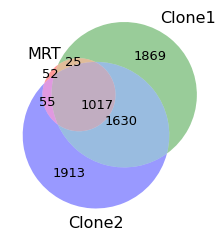

In [14]:
common_df['mut'] = common_df.apply(lambda row: row['CHROM'] + str(row['POS']) + row['REF'] + row['ALT'],axis=1)
set1 = common_df[common_df['MRT']==True]
set1 = set(set1['mut'].tolist())
set2 = common_df[common_df['Clone1']==True]
set2 = set(set2['mut'].tolist())
set3 = common_df[common_df['Clone2']==True]
set3 = set(set3['mut'].tolist())
title = 'tumor2 and clones'
names = ['MRT','Clone1','Clone2']
out = venn3([set1,set2,set3], names)

for text in out.set_labels:
    text.set_fontsize(16)
for text in out.subset_labels:
    text.set_fontsize(13)

plt.savefig('./figures_paper/venn_clones.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

## Analyse results

In [15]:
def color_sigs (sigs):

    colors_dict = {}
    colors_list = []
    greys = ['gainsboro','darkgrey','gray','lightgrey','lightgray','silver','dimgrey','dimgray','slategrey']
    i = 0
    for sig in sigs:
        if 'potential' in sig:
            color = greys[i]
            i+=1
        elif 'SBS1-' in sig or sig=='SBS1':
            color = 'orange'
        elif 'SBS2-' in sig or sig=='SBS2':
            color = 'olive'
        elif 'SBS3-' in sig or sig=='SBS3':
            color = 'mediumpurple'
        elif 'SBS5-' in sig or sig=='SBS5':
            color = 'skyblue'
        elif 'SBS7a' in sig:
            color = 'teal'
        elif 'SBS12' in sig:
            color = 'seagreen'
        elif 'SBS13' in sig:
            color = 'purple'
        elif 'SBS17b' in sig:
            color = 'pink'
        elif 'SBS18' in sig:
            color = 'royalblue'
        elif 'SBS31' in sig:
            color = 'firebrick'
        elif 'SBS32' in sig:
            color = 'plum'
        elif 'SBS35' in sig:
            color = 'lightcoral'
        elif 'SBS40' in sig:
            color = 'turquoise'
#         elif 'SBS45' in sig:
#             color = 'lightgrey'
        elif 'SBS60' in sig:
            color = 'darkseagreen'
        else:
            color = greys[i]
            i+=1
            pass
        colors_dict[sig] = color
        colors_list.append(color)
    return colors_dict,colors_list

## Results with clonal mutations

### mSigAct

In [16]:
order_list = ['AQ5186_vs_AQ5174','AX4958_vs_AQ5174','AX4961_vs_AQ5174']

In [17]:
#prepare df with each mSigAct
path_sbs31 = './msigact/output_sbs31/results.clones.matrix.tsv.mSigAct.SBS31.tsv'
df = pd.read_csv(path_sbs31,sep='\t')
df = df[['SBS1','SBS5','SBS18','SBS40','SBS31']]
SBS31_df = df.reindex(order_list)
path_sbs35 = path_sbs31.replace('31','35')
df = pd.read_csv(path_sbs35,sep='\t')
df = df[['SBS1','SBS5','SBS18','SBS40','SBS35']]
SBS35_df = df.reindex(order_list)

In [18]:
SBS31_df

,SBS1,SBS5,SBS18,SBS40,SBS31
AQ5186_vs_AQ5174,66.243491,843.025314,0.000000,239.731195,0
AX4958_vs_AQ5174,175.043912,2067.673576,699.634829,1598.647683,0
AX4961_vs_AQ5174,230.287272,1700.791737,534.569998,2149.350993,0


### mSigAct SBS31

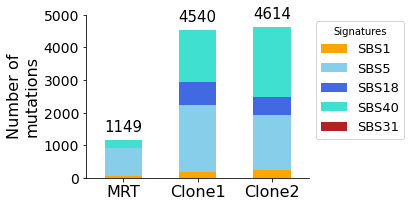

In [19]:
df = SBS31_df
sigs = df.columns.tolist()
colors_dict,colors_list = color_sigs(sigs)
labels = ['MRT','Clone1','Clone2']
pvals = []
size_text = 13
figsize=(4,3)
legend=True
ylim = 5000
title = ''

ax = df.plot(kind='bar', stacked=True, figsize=figsize,color=colors_list,legend=legend)

if legend == True:
    plt.legend(title='Signatures', bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 13})

plt.xticks(range(0,len(df)), labels, rotation=0,size=16)
plt.yticks(np.arange(0, ylim +1, 1000), size=14)
plt.ylabel(ylabel='Number of\nmutations',fontsize=16)
plt.title(title,size=20,pad=20)
plt.ylim(0,ylim)

plt.xlabel(' ')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

muts_MRT = round(df[['SBS1','SBS5','SBS18','SBS40','SBS31']].sum(axis=1)[0],0)
muts_clone1 = df[['SBS1','SBS5','SBS18','SBS40','SBS31']].sum(axis=1)[1]
muts_clone2 = df[['SBS1','SBS5','SBS18','SBS40','SBS31']].sum(axis=1)[2]

plt.text(0,muts_MRT+400,str(int(muts_MRT)),color='black', fontweight='normal',ha='center',va='center',size=15)
plt.text(1,muts_clone1+400,str(int(muts_clone1)),color='black', fontweight='normal',ha='center',va='center',size=15)
plt.text(2,muts_clone2+400,str(int(muts_clone2)),color='black', fontweight='normal',ha='center',va='center',size=15)
        
        
plt.savefig('./figures_paper/msigact_sbs31_clones_clonals.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

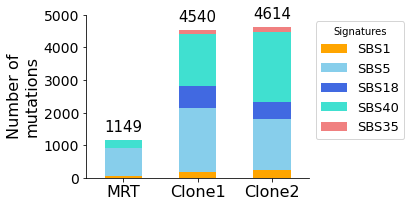

In [20]:
df = SBS35_df
sigs = df.columns.tolist()
colors_dict,colors_list = color_sigs(sigs)
labels = ['MRT','Clone1','Clone2']
pvals = []
size_text = 13
figsize=(4,3)
legend=True
ylim = 5000
title = ''

ax = df.plot(kind='bar', stacked=True, figsize=figsize,color=colors_list,legend=legend)

if legend == True:
    plt.legend(title='Signatures', bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 13})

plt.xticks(range(0,len(df)), labels, rotation=0,size=16)
plt.yticks(np.arange(0, ylim +1, 1000), size=14)
plt.ylabel(ylabel='Number of\nmutations',fontsize=16)
plt.title(title,size=20,pad=20)
plt.ylim(0,ylim)

plt.xlabel(' ')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

muts_MRT = round(df[['SBS1','SBS5','SBS18','SBS40','SBS35']].sum(axis=1)[0],0)
muts_clone1 = df[['SBS1','SBS5','SBS18','SBS40','SBS35']].sum(axis=1)[1]
muts_clone2 = df[['SBS1','SBS5','SBS18','SBS40','SBS35']].sum(axis=1)[2]

plt.text(0,muts_MRT+400,str(int(muts_MRT)),color='black', fontweight='normal',ha='center',va='center',size=15)
plt.text(1,muts_clone1+400,str(int(muts_clone1)),color='black', fontweight='normal',ha='center',va='center',size=15)
plt.text(2,muts_clone2+400,str(int(muts_clone2)),color='black', fontweight='normal',ha='center',va='center',size=15)
        
        
plt.savefig('./figures_paper/msigact_sbs35_clones_clonals.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

In [21]:
def plot_2_bars (df,sample_id,title,ylim,y_val1,y_val2,xlabel,ylabel):
    df1 = df[df.index.isin([sample_id])]

    other_sigs = ['SBS1','SBS5','SBS18','SBS40']

    df1['other_sigs'] = df1[other_sigs].sum(axis=1)
    df1 = df1[['SBS31','other_sigs']]

    figsize = (2,2)

    fig, ax = plt.subplots(figsize=figsize)

    for x,val in enumerate(df1['SBS31'].tolist()):
        if sample_id in ['AU2202']:          
            pos = x-0.2
            ax.bar(pos, 0,color='firebrick',width=0.2)
        else:
            pos = x-0.2
            ax.bar(pos, val,color='firebrick',width=0.2)            


    for x,val in enumerate(df1['other_sigs'].tolist()):
        pos = x +0.2
        ax.bar(pos, val,color='grey',width=0.2)

    plt.xticks([])
    plt.xlabel(xlabel,size=14)
    plt.title(title,size=20,pad=20)
    plt.ylim(0,ylim)
    plt.ylabel(ylabel,size=16)
    plt.yticks(size=12)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)

    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    
    for i, v in enumerate(df1['SBS31']):
        if sample_id in ['AU2202']:
            plt.text(i-0.2, v+y_val1, '0', color='firebrick', fontweight='normal',ha='center',va='center',size=15)
        else:
            plt.text(i-0.2, v+y_val1, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
            
        for i, v in enumerate(df1['other_sigs']):
            plt.text(i+0.2, v+y_val2, str(int(round(v,0))), color='grey', fontweight='normal',ha='center',va='center',size=15)


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


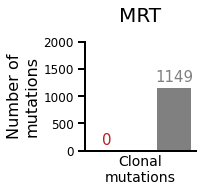

In [22]:
df = SBS31_df.copy()
sample_id = 'AQ5186_vs_AQ5174'

ylim = 2000
title = 'MRT'
y_val1 = 200
y_val2 = 200
xlabel = 'Clonal\nmutations'
ylabel = 'Number of\nmutations'
plot_2_bars (df,sample_id,title,ylim,y_val1,y_val2,xlabel,ylabel)
plt.savefig('./figures_paper/mrt_msigact_clonal_sbs31.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


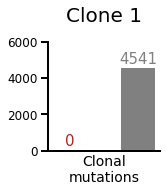

In [23]:
df = SBS31_df.copy()
sample_id = 'AX4958_vs_AQ5174'

ylim = 6000
title='Clone 1'
y_val1=500
y_val2=500
plot_2_bars (df,sample_id,title,ylim,y_val1,y_val2,xlabel='Clonal\nmutations',ylabel='')
plt.xticks([])
plt.ylabel('')
plt.xlabel('Clonal\nmutations',size=14)
plt.savefig('./figures_paper/clone1_msigact_clonal_sbs31.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


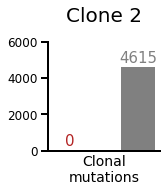

In [24]:
df = SBS31_df.copy()
sample_id = 'AX4961_vs_AQ5174'

ylim = 6000
title='Clone 2'
y_val=500
plot_2_bars (df,sample_id,title,ylim,y_val1,y_val2,xlabel='Clonal\nmutations',ylabel='')
plt.xticks([])
plt.ylabel('')
plt.xlabel('Clonal\nmutations',size=14)
plt.savefig('./figures_paper/clone2_msigact_clonal_sbs31.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

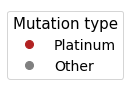

In [25]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(figsize=(1,1))
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
                          markersize=8, label='Platinum')
other_signatures = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                          markersize=8, label='Other')

plt.legend(handles=[sbs31,other_signatures],bbox_to_anchor=(1,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)
plt.savefig('./figures_paper/legend_platinum_vs_other.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
